## Practical 1: Water erosion on cropland ##
The idea of this practical is to study the changes in potential soil erosion rates on cropland in regions with different climate zones, and discuss the contribution of land use change versus climate change to the temporal trends over the period 1975-2005.
<br>
1) Calculate soil erosion rates for three different setups:
<br>
a. Land use change and climate change both activated
<br>
b. Land use change only activated
<br>
c. Climate change only activated
<br>
Download and unzip the data file for your region: input_BRA.zip for Brazil, input_EU_east.zip for Eastern Europe, or input_EU_west.zip for  Western Europe. Move/Copy the folders that are in this file to your work directory. In your work directory create an empty ‘output’ directory, where your will store the results of the model. In the output directory create empty directory ‘erosion’, and within ‘erosion’ 2 empty directories ‘CC’ and ‘LUC’.
<br>
Now launch spyder in your created environment.
<br>
For windows: Open Anaconda prompt and type: spyder activate py27_test (or py36_test)
<br>
For Linux/Mac: Open a terminal and type spyder activate py27_test (or py36_test)
<br>
In spyder open the file ‘erosion_run.py’. Here you have to change the workdir to your work directory,  and the simulation setup: ‘LUC’ for land use change-only, ‘CC’ for climate change only and ‘CC+LUC’ for land use change and climate change. You will have to run all three simulations.
<br>
To run the file simply click the green arrow or in the IPython console navigate to the E_code directory and type execfile(‘erosion_run.py’).
<br>

In [2]:
# -*- coding: utf-8 -*-
import numpy as np
from netCDF4 import Dataset

###########################################
#This script calculates global yearly average soil erosion rates
#Transient simulation = changing land use and climate (CC+LUC), changing climate only (CC),
#or changing land use only (LUC)
#Equilibrium simulation = average soil erosion rates for a specific period
#When using this model code please cite: "Naipal ,V., Ciais, P., Wang, Y., Lauerwald, R.,
#Guenet, B., Van Oost, K. (2018). Global soil organic carbon removal by water erosion under
#climate change and land use change during 1850–2005 AD. Biogeosciences, 15, 4459–4480,
#https://doi.org/10.5194/bg-15-4459-2018"
############################################

print ('start script')

#settings
workdir= '/home/wieka20/Dokumente/Postdoc_LMU/Teaching/Practical/' #Enter here your work directory
years=range(1975,2006) #transient period
reg='BRA' #select your region, 'EU_east' for Eastern Europe, 'EU_west' for Western Europe, 'BRA' for Brazil or 'AUS' for Australia
simulation="CC+LUC" #select simulation type from: equilibrium,CC+LUC,CC,LUC
lc=1 #select vegetation type crop, 0=tree, 2=grass, 3=bare
veget="crop" #select vegetation type tree,crop,grass or bare

#general input data
data = Dataset('%s/input_%s/rest/S_scaled_5m_%s.nc' % (workdir,reg,reg),'r') #S factor
S= data.variables['s'][:]
lat0=data.variables['lat'][0]
lon0=data.variables['lon'][0]
rows=len(S[:,0]);kols=len(S[0]) 
S[S<0.] = 0.
S[np.isnan(S)==True] = 0.
S=np.ravel(S)
data.close()

data = Dataset('%s/input_%s/rest/K_volcanic_nogravel_5m_%s.nc' % (workdir,reg,reg),'r')
K = data.variables['k'][:] # K factor without gravel correction but with volcanic soil correction
K[K<0.] = 0.
K[np.isnan(K)==True] = 0.
K=np.ravel(K)
data.close()

data = Dataset('%s/input_%s/rest/gravel_topsoil_5m_%s.nc' % (workdir,reg,reg),'r')
gravel = data.variables['GRAV'][:] # gravel content in %
gravel=gravel.astype(float)
gravel[gravel<0.] = 0.
gravel[np.isnan(gravel)==True] = 0.
gravel = np.ravel(gravel)
data.close()

print ('read input data part 1: done')

if simulation =='equilibrium':
  ####################################
  # Equilibrium 
  ###################################

  data2 = Dataset('%s\input_%s\R_factor\ISIMIP2b_R_1975-1985_mean_5m_%s.nc' % (workdir,reg,reg),'r') # R factor
  R = data2.variables['r'][:] 
  R[R<0]=0.;R[R>10e35]=0.;R[np.isnan(R)==True] = 0.
  R=np.ravel(R)
  data2.close()    

  nc = Dataset('%s\input_%s\C_factor\C_crop_1975-1985_mean_5m_%s.nc' % (workdir,reg,reg),'r') # C factor   
  C = nc.variables['c_lc'][:]
  C[C<0]=0.;C[np.isnan(C)==True] = 0.
  C=np.ravel(C)   
  
  print ('read input data part 2: done')
  
  #calculate erosion for this timeperiod
  E=S*R*K*C #potential erosion
  E[gravel>12.]=E-(0.8*E) #erosion reduction by 80% if gravel on cropland >12%
  E[E>100.]=100. #max erosion rate is 100t/ha/y
  E = E.reshape(rows,kols)      
  #output
  output = Dataset('%s\output\erosion\E_%s_mean_1975-1985_%s.nc' % (workdir,veget,reg),'w')
  output.createDimension('latitude',rows)
  output.createDimension('longitude',kols)
  var=output.createVariable('latitude','f',('latitude',))
  var[:]=[lat0-n*0.0833 for n in range(rows)]
  var=output.createVariable('longitude','f',('longitude',))
  var[:]=[lon0+n*0.0833 for n in range(kols)]
  output.createVariable('E','d',('latitude','longitude',))
  output.variables['E'][:] = E
  output.close()  

  print ('erosion output: done')
    
  nc.close()    

if simulation =='CC+LUC':
  ####################################
  # CC + LUC
  ###################################
  for t in years:
    data = Dataset('%s/input_%s/R_factor/ISIMIP2b_R_%04i_5m_%s.nc' % (workdir,reg,t,reg),'r') # R factor
    R = data.variables['r'][:] 
    R[R<0]=0.;R[R>10e35]=0.
    R[np.isnan(R)==True] = 0.
    R=np.ravel(R)
    data.close()    
      
    data = Dataset('%s/input_%s/C_factor/C_crop_%04i_5m_%s.nc' % (workdir,reg,t,reg),'r')
    C = data.variables['c_lc'][:] # C factor for crop
    C[C<0]=0.
    C[np.isnan(C)==True] = 0.
    C=np.ravel(C)   
    data.close()
    
    #calculate erosion for this timeperiod
    E=S*R*K*C #potential erosion
    E[gravel>12.]=E[gravel>12.]-(0.8*E[gravel>12.]) #erosion reduction by 80% if gravel on cropland >12%
    E[E>100.]=100. #max erosion rate is 100t/ha/y
    E = E.reshape(rows,kols) 
    
    #output 
    output = Dataset('%s/output/erosion/E_%s_%04i_%s.nc' % (workdir,veget,t,reg),'w')
    output.createDimension('latitude',rows)
    output.createDimension('longitude',kols)
    var=output.createVariable('latitude','f',('latitude',))
    var[:]=[lat0-n*0.0833 for n in range(rows)]
    var=output.createVariable('longitude','f',('longitude',))
    var[:]=[lon0+n*0.0833 for n in range(kols)]
    output.createVariable('E','d',('latitude','longitude',))
    output.variables['E'][:] = E
    output.close() 

if simulation =='CC':
  ####################################
  # CC only (LUC=set to 1975-1985)
  ###################################
  for t in years:
    data2 = Dataset('%s/input_%s/R_factor/ISIMIP2b_R_%04i_5m_%s.nc' % (workdir,reg,t,reg),'r') # R factor
    R = data2.variables['r'][:] 
    R[R<0]=0.
    R[R>10e35]=0.
    R[np.isnan(R)==True] = 0.
    R=np.ravel(R)
    data2.close()    
      
    data1 = Dataset('%s/input_%s/C_factor/CC/C_crop_%04i_5m_%s.nc' % (workdir,reg,t,reg),'r') # C factor
    C = data1.variables['c_lc'][:]
    C[C<0]=0.;C[np.isnan(C)==True] = 0.
    C=np.ravel(C)   
      
    #calculate erosion for this timeperiod
    E=S*R*K*C #potential erosion
    E[gravel>12.]=E[gravel>12.]-(0.8*E[gravel>12.]) #erosion reduction by 80% if gravel on cropland >12%
    E[E>100.]=100. #max erosion rate is 100t/ha/y
    E = E.reshape(rows,kols) 
     
    #output
    output = Dataset('%s/output/erosion/CC/E_%s_%04i_%s.nc' % (workdir,veget,t,reg),'w')
    output.createDimension('latitude',rows)
    output.createDimension('longitude',kols)
    var=output.createVariable('latitude','f',('latitude',))
    var[:]=[lat0-n*0.0833 for n in range(rows)]
    var=output.createVariable('longitude','f',('longitude',))
    var[:]=[lon0+n*0.0833 for n in range(kols)]
    output.createVariable('E','d',('latitude','longitude',))
    output.variables['E'][:] = E
    output.close()   

if simulation =='LUC':
  ####################################
  # LUC only (CC=set to 1975-1985)
  ###################################
  data0 = Dataset('%s/input_%s/R_factor/ISIMIP2b_R_1975-1985_mean_5m_%s.nc' % (workdir,reg,reg),'r') # R factor
  R = data0.variables['r'][:] 
  R[R<0]=0.;R[R>10e35]=0.
  R[np.isnan(R)==True] = 0.
  R=np.ravel(R)
  data0.close() 

  for t in years:     
    data1 = Dataset('%s/input_%s/C_factor/LUC/C_crop_%04i_5m_%s.nc' % (workdir,reg,t,reg),'r') # C factor
    C = data1.variables['c_lc'][:]
    C[C<0]=0.;C[np.isnan(C)==True] = 0.
    C=np.ravel(C)   
      
    #calculate erosion for this timeperiod
    E=S*R*K*C #potential erosion
    E[gravel>12.]=E[gravel>12.]-(0.8*E[gravel>12.]) #erosion reduction by 80% if gravel on cropland >12%
    E[E>100.]=100. #max erosion rate is 100t/ha/y
    E = E.reshape(rows,kols) 
    
    #output
    output = Dataset('%s/output/erosion/LUC/E_%s_%04i_%s.nc' % (workdir,veget,t,reg),'w')
    output.createDimension('latitude',rows)
    output.createDimension('longitude',kols)
    var=output.createVariable('latitude','f',('latitude',))
    var[:]=[lat0-n*0.0833 for n in range(rows)]
    var=output.createVariable('longitude','f',('longitude',))
    var[:]=[lon0+n*0.0833 for n in range(kols)]
    output.createVariable('E','d',('latitude','longitude',))
    output.variables['E'][:] = E
    output.close()        

start script
read input data part 1: done


/home/wieka20/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in less
/home/wieka20/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less
/home/wieka20/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in less


**2) Plot (A) soil erosion timeseries and (B) quantile box plot**
<br>
a. We start with looking at the timeseries of soil erosion under different forcing regarding the three different simulations. Open the script erosion_analysis.py. Under settings you can change the reg variable to your region, and the workdir to your directory. Then go to exercise 2A. We will now run only exercise 2A and have a look at the results so comment out everything below this exercise by doing this:
<br>

“ “ “ Code “ “ “
<br>

Please save the figure you get in your output directory. You can also use the command: plt.savefig(‘file.png‘)
<br>

If you get an error importing Basemap after running this line ‘from mpl_toolkits.basemap import Basemap’, please see instructions between lines 11 and 19.

/home/wieka20/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater
/home/wieka20/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater
/home/wieka20/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in greater


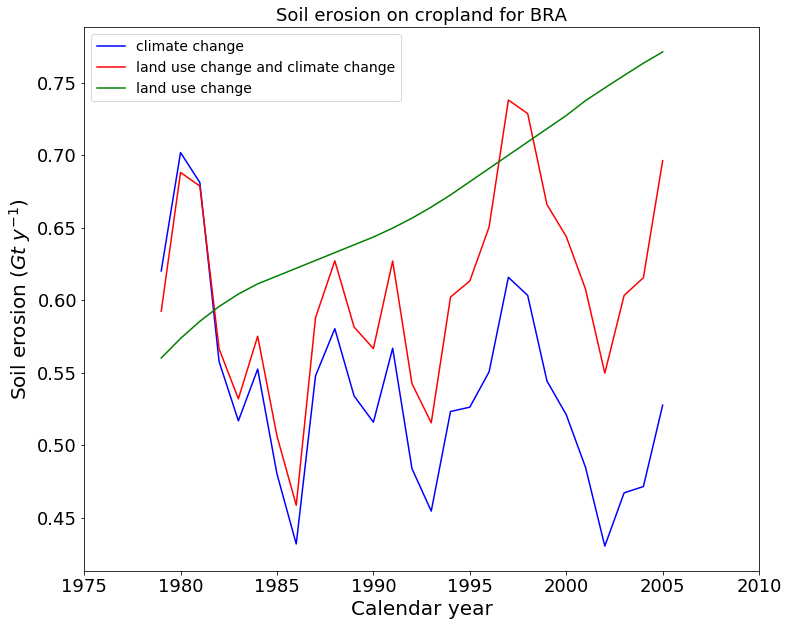

In [7]:
# -*- coding: utf-8 -*-
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib import *
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
import conda

###Do the following only if importing Basemap does not work ###
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
#check where basemap is installed on your system and modify the following line.
#In my case it's in: '/home/wieka20/anaconda3/Library/share'
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj') 
os.environ["PROJ_LIB"] = proj_lib
###
from mpl_toolkits.basemap import Basemap

# function for moving average
def movingaverage(values,window):
  weights = np.repeat(1.0,window)/window
  smas = np.convolve(values,weights,'valid')
  return smas
#setting
years=range(1975,2006)
workdir='/home/wieka20/Dokumente/Postdoc_LMU/Teaching/Practical/'
reg='BRA' #select your region, 'EU_east' for Eastern Europe, 'EU_west' for Western Europe, 'BRA' for Brazil or 'AUS' for Australia

# input datasets
data= Dataset('%s/input_%s/rest/Global_land_grid_area_5m_grid_ha_%s.nc' % (workdir,reg,reg),'r')
A= data.variables['area'][:] #area of each pixel in ha
rows=len(A[:,0]);kols=len(A[0]) 
lats=np.array(data.variables['lat'][:])
lat0=lats[0];lat1=lats[-1]
lons=np.array(data.variables['lon'][:])
lon0=lons[0];lon1=lons[-1]
llons,llats=np.meshgrid(lons,lats)
A = np.ravel(A)
A[A<0.]=0.
data.close()

######################################
# Exercise 2A: Calculate and plot timeseries
######################################

E_cc_luc=[];E_cc=[];E_luc=[]
for y in range(len(years)):
  #print years[y]
  #erosion CC + LUC
  data = Dataset('%s/output/erosion/E_crop_%04i_%s.nc' % (workdir,years[y],reg),'r')
  E_sum = np.array(data.variables['E'][:])
  E_sum[E_sum==0.]=np.nan
  E_sum[E_sum>100.]=np.nan #exclude unrealistic values
  E_sum=np.ravel(E_sum)*A
  E_cc_luc.append(np.nansum(E_sum)) #global total
  data.close()
  #erosion CC
  data = Dataset('%s/output/erosion/CC/E_crop_%04i_%s.nc' % (workdir,years[y],reg),'r')
  E_sum = np.array(data.variables['E'][:])
  E_sum[E_sum==0.]=np.nan
  E_sum[E_sum>100.]=np.nan 
  E_sum=np.ravel(E_sum)*A
  E_cc.append(np.nansum(E_sum)) 
  data.close()  
  #erosion LUC
  data = Dataset('%s/output/erosion/LUC/E_crop_%04i_%s.nc' % (workdir,years[y],reg),'r')
  E_sum = np.array(data.variables['E'][:])
  E_sum[E_sum==0.]=np.nan
  E_sum[E_sum>100.]=np.nan
  E_sum=np.ravel(E_sum)*A
  E_luc.append(np.nansum(E_sum)) 
  data.close()

E_cc_luc=np.asarray(E_cc_luc)*1E-9 #tonnes to Gt
E_cc=np.asarray(E_cc)*1E-9
E_luc=np.asarray(E_luc)*1E-9

#plotting-moving average
fig, ax = plt.subplots(figsize=(15,10))
fig.subplots_adjust(right=0.75)
ax.plot(years[len(years)-len(movingaverage(E_cc,5)):],movingaverage(E_cc,5),'b-',label='climate change')
ax.plot(years[len(years)-len(movingaverage(E_cc_luc,5)):],movingaverage(E_cc_luc,5),'r-',label='land use change and climate change')
ax.plot(years[len(years)-len(movingaverage(E_luc,5)):],movingaverage(E_luc,5),'g-',label='land use change')
ax.set_xlim([1975,2010])
#ax.set_ylim([2.,5..])
ax.set_xlabel('Calendar year',fontsize=20)
ax.set_ylabel('Soil erosion ($Gt$ $y^{-1}$)',fontsize=20)
ax.set_title('Soil erosion on cropland for %s' % (reg),fontsize=18)
ax.tick_params('x',labelsize=18)
ax.tick_params('y',labelsize=18)
ax.legend(loc='upper left',fontsize=14)
plt.show()
#plt.savefig('%s/output/figure.png' %(workdir))
#plt.close()

b. Here we will compare how the average soil erosion for the specific climate zone changed between the start of the time period (1975-1985) and the end of the time period (1995-2005). For this we will plot a quantile boxplot that includes the following statistics: median, mean, 25th and 75th percentile and outliers. Go to exercise 2B and run that part. You can just select and copy the part you want to be executed and paste it into the IPython console. Save the figure you get. You might need to adjust the value range ax.set_ylim([0.,5.]), depending on the maximum of your datarange.
<br>

1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004


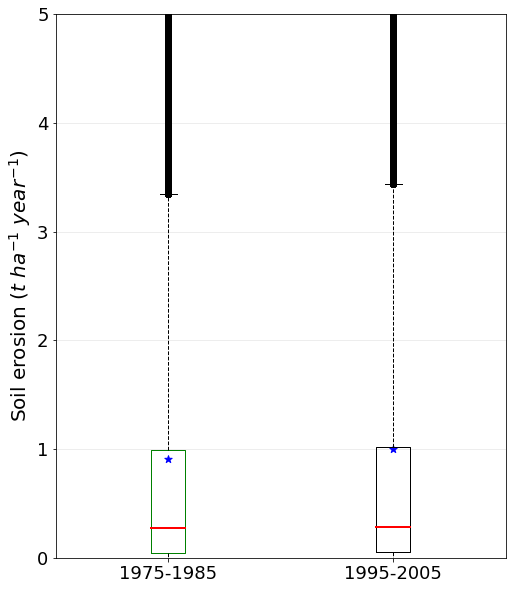

In [8]:
######################################
# Exercise 2B:Calculate and plot statistical quantiles for the period 1995-2005 vs 1975-1985
######################################
#calculate,compare and plot quantiles as a boxplot per bin sample data
E0=0.;E1=0.
for y in range(1975,1985):
  print(y)
  #erosion CC + LUC
  data = Dataset('%s/output/erosion/E_crop_%04i_%s.nc' % (workdir,y,reg),'r')
  E = np.array(data.variables['E'][:])
  E[E>20.]=20. #exclude unrealistic values
  E0+=np.ravel(E) #t/ha/y  
  data.close()
for y in range(1995,2005):
  print(y)
  #erosion CC + LUC
  data = Dataset('%s/output/erosion/E_crop_%04i_%s.nc' % (workdir,y,reg),'r')
  E = np.array(data.variables['E'][:])
  E[E>20.]=20.
  E1+=np.ravel(E) 
  data.close()
E_1975_1985=E0/10.;E_1995_2005=E1/10.
E_1975_1985=E_1975_1985[E_1975_1985>0.001];E_1995_2005=E_1995_2005[E_1995_2005>0.001]

data=[E_1975_1985,E_1995_2005]
means=[np.mean(E_1975_1985),np.mean(E_1995_2005)]
fig, ax= plt.subplots()
fig.set_size_inches(10,10)
fig.subplots_adjust(right=0.75)
ax.yaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.5)
ax.set_axisbelow(True)
bp=ax.boxplot(data,notch=0,vert=1,whis=2.5)
#ax.set_yscale('log')
for i in range(2):
  if i==0:
    plt.setp(bp['boxes'][i],color='g')
    plt.setp(bp['whiskers'][i],color='g')
    #plt.setp(bp['fliers'][i],color='g',marker='+')
  else:
    plt.setp(bp['boxes'][i],color='k')
    plt.setp(bp['whiskers'][i],color='k')
    #plt.setp(bp['fliers'][i],color='k',marker='+')
for median in bp['medians']:
  median.set(color='r',linewidth=2)
for whisker in bp['whiskers']:
  whisker.set(color='k',linestyle='--')
xtickNames=plt.setp(ax,xticklabels=np.array(['1975-1985','1995-2005']))
means_all=[means[0],means[1]]
plt.scatter(np.arange(1,3),means_all,color='b',marker='*',s=60)
ax.set_ylabel('Soil erosion ($t$ $ha^{-1}$ $year^{-1}$)',fontsize=20)
ax.set_ylim([0.,5.])
ax.tick_params(axis='y',labelsize=18)
ax.tick_params(axis='x',labelsize=18)
plt.show()
#plt.savefig('%s/output/figure.png' %(workdir)) 
#plt.close()


c. If you have time you can also look at the histogram of the distribution of different erosion events by running ex. 2C. You can change the ax.set_ylim value to have a closer look at the frequencies.
<br>

/home/wieka20/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


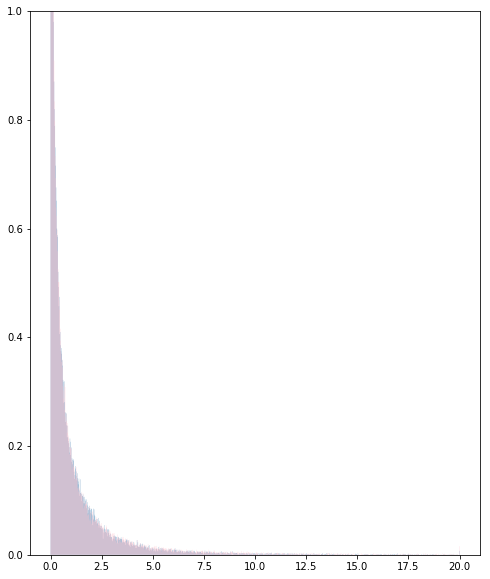

In [9]:
######################################
#Exercise 2C: plot histograms and compare the distribution of erosion between 1995-2005 and 1975-1985
######################################
fig, ax= plt.subplots()
fig.set_size_inches(10,10)
fig.subplots_adjust(right=0.75)
ax.hist(E_1975_1985, bins=1000, normed=True, alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none')
ax.hist(E_1995_2005, bins=1000, normed=True, alpha=0.5,
         histtype='stepfilled', color='pink',
         edgecolor='none')
ax.set_ylim([0.,1.])
plt.show()
#plt.savefig('%s/output/figure.png' %(workdir)) 
#plt.close()

**3) Plot map of regional soil erosion**
<br>
To create a map of the spatial distribution of soil erosion over the globe we will use “Basemap” in python (exercise 3). You can plot either or both the means of the first period (1975-1985) or the last period (1995-2005) to see in which regions soil erosion might have changed and due to land use change or climate change. For this you can change the variable ‘data’ between E0/10 or E1/10. You can also play with the erosion due to land use change only or climate change only. For Western Europe you need to limit the upper latitude to 55. degrees to have a better map, set urcrnrlat=55.. For eastern Europe you need to limit both the upper latitude and the most left longitude to zoom into the region.

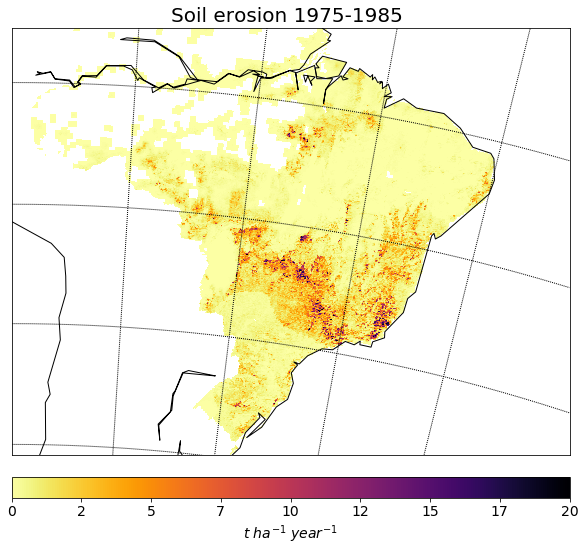

In [10]:
######################################
#Exercise 3: plot Basemap
######################################
data=(E0/10.).reshape(rows,kols)
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
m=Basemap(projection='lcc',resolution='c',lat_0=(lat1-lat0)/2., lon_0=lon0, llcrnrlon=lon0,llcrnrlat=lat1,urcrnrlon=lon1,urcrnrlat=lat0)
m.drawcoastlines()
m.drawparallels(np.arange(lat0,lat1,-10))
m.drawmeridians(np.arange(lon0,lon1,10))
x,y=m(llons,llats)
cmap=plt.cm.inferno_r
data=np.ma.masked_where(data==0.,data)
cmap.set_bad('white')
cs=m.pcolormesh(x,y,data,vmin=0.,vmax=20.,cmap=cmap)
plt.title('Soil erosion 1975-1985 ',fontsize=20)
cbar = m.colorbar(cs,location='bottom',pad="5%",format='%i')
cbar.set_label('$t$ $ha^{-1}$ $year^{-1}$',fontsize=14)
cbar.ax.tick_params(labelsize=14)
plt.show()
#plt.savefig('%s/output/figure.png' %(workdir))  
#plt.close()

## Practical 2: Carbon erosion on cropland##
 <br>
During this part we will try to understand how much carbon is lost due to erosion on cropland in the different regions, and study the role of the different global changes (land use change and climate change) in the loss fluxes during the period 1975-2005. As we do not have all the tools available to run the carbon emulator, based on the ORCHIDEE LSM, and we do not have so much time I have prepared the carbon (C)erosion output files from my study published last year (Naipal et al., 2018). Go to the following google drive link and download the SOC data, and the file ‘Area_ORCHIDEE.nc’: 
<br>
<br>
https://drive.google.com/drive/folders/1SHOR9mF_A7qZvcyOowadr_LDlJhST1XJ?usp=sharing
<br>
<br>
In this part of the practical we will do the following:
<br>
<br>
1) (a) Plot timeseries and (b) the quantile box plot of C erosion rates per region.
<br>
<br>
We will use the C erosion rate files stored in SOC_data folder. You can have a look at the input of the data (format: Em_CE_cc_luc_1975.nc) if you have netcdf installed by using ncdump -h filename. It has 2 variables: E (carbon erosion in g/m2/year) and SOC (total SOC stock in g/m2 up to 2m depth).
Open the file Cerosion_analysis.py and change the settings according to your previous specifications. Then execute exercise 1A and B, save the figures you get. When executing exercise 2 to plot the basemap take care of the dataset maximum, that you might need to adjust.
<br>
<br>
2) Plot a map of C erosion rates for the region like in part 1 of the practical

/home/wieka20/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:1018: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/wieka20/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "middle right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005


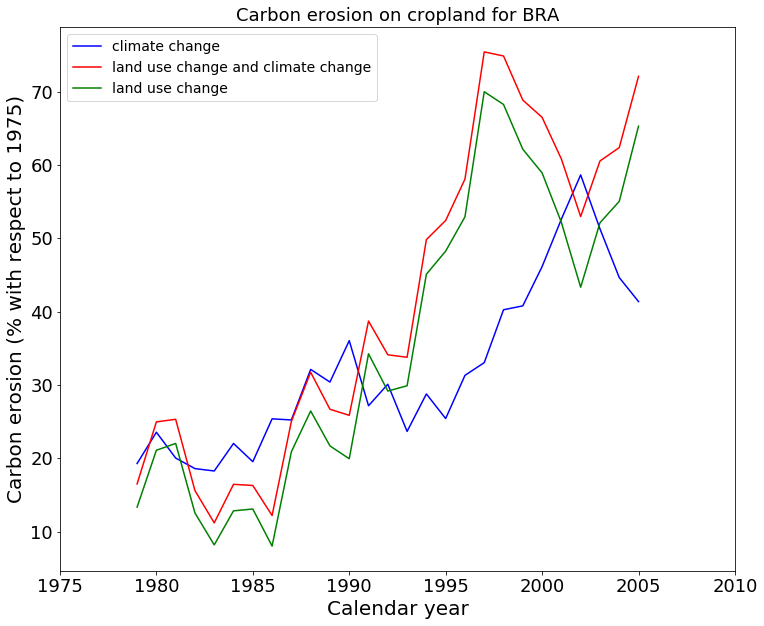

1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004


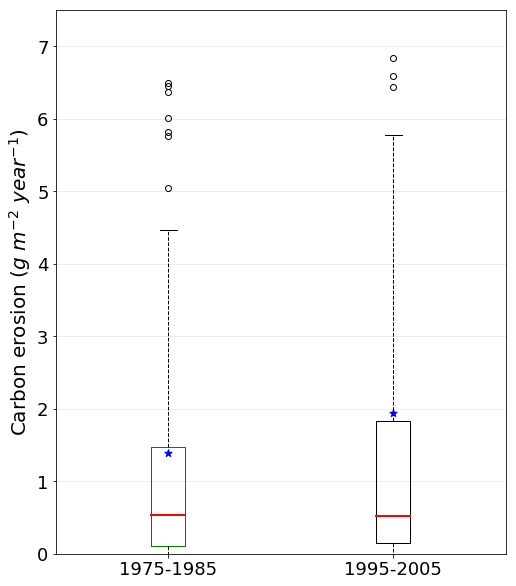

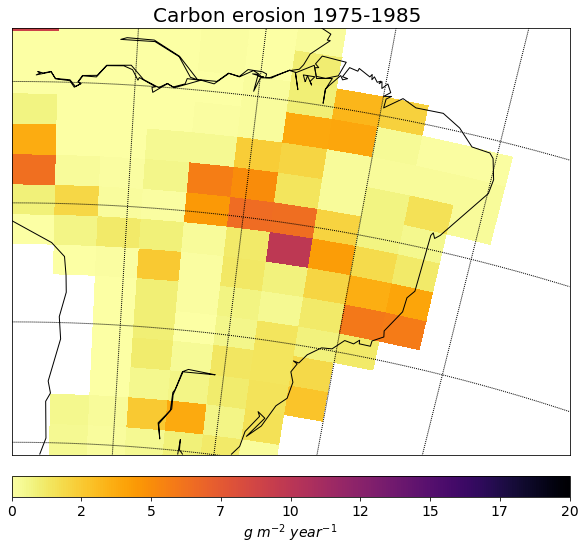

In [11]:
# -*- coding: utf-8 -*-
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib import *
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
import conda

###Do the following only if importing Basemap does not work ###
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
#check where basemap is installed on your system and modify the following line.
#run in terminal for linux: find `conda info --base` -name epsg
#In my case it's in: C:\\Users\\adminuser\\Anaconda2\\Library\\share
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj') 
os.environ["PROJ_LIB"] = proj_lib
###

from mpl_toolkits.basemap import Basemap

# function for moving average
def movingaverage(values,window):
  weights = np.repeat(1.0,window)/window
  smas = np.convolve(values,weights,'valid')
  return smas
#setting
years=range(1975,2006)
workdir='/home/wieka20/Dokumente/Postdoc_LMU/Teaching/Practical/'
reg='BRA' #select your region, 'EU_east' for Eastern Europe, 'EU_west' for Western Europe, 'BRA' for Brazil or 'AUS' for Australia

#set regional settings
if reg=='AUS':
    lat0=-8.1;lat1=-45.1;lon0=111.1; lon1=158.
if reg=='BRA':
    lat0=6.;lat1=-35.;lon0=-75.; lon1=-32.
if reg=='EU_east':
    lat0=82.;lat1=19.85;lon0=11.34;lon1=69.72
if reg=='EU_west':
    lat0=82.;lat1=19.85;lon0=-31.1;lon1=11.34
nc=Dataset('%s/input/Area_ORCHIDEE.nc' %(workdir),'r')
lats=np.array(nc.variables['lat'][:61])
lons=np.array(nc.variables['lon'][:-1])

rows=[]
for i in range(len(lats)):
  if lats[i]>=lat1 and lats[i]<=lat0:
    rows.append(i)
kols=[]
for j in range(len(lons)):
  if lons[j]>=lon0 and lons[j]<=lon1:
    kols.append(j)
rows=np.asarray(rows)
kols=np.asarray(kols)

area=nc.variables['Areas'][rows[0]:rows[-1]+1,kols[0]:kols[-1]+1]
contfrac=nc.variables['CONTFRAC'][rows[0]:rows[-1]+1,kols[0]:kols[-1]+1]
lats_sel=nc.variables['lat'][rows[0]:rows[-1]+1]
lons_sel=nc.variables['lon'][kols[0]:kols[-1]+1]
AREA=area*contfrac
AREA[AREA<0.]=0.;AREA[abs(AREA)>1.e36]=0.
land=contfrac<=1.
llons,llats=np.meshgrid(lons_sel,lats_sel)
nc.close()

######################################
# Exercise 1A: Calculate and plot timeseries
######################################
CE_cc_luc=[];CE_cc=[]
for y in range(len(years)):
  print(years[y])
  #C erosion CC + LUC
  data = Dataset('%s/input/SOC_data/Em_CE_cc_luc_crop_%04i.nc' % (workdir,years[y]),'r')
  CE = np.array(data.variables['E'][rows[0]:rows[-1]+1,kols[0]:kols[-1]+1]) #g/m2
  CE_cc_luc.append(np.nansum(CE*AREA)) #global total
  data.close()
  #C erosion CC
  data = Dataset('%s/input/SOC_data/Em_CE_cc_crop_%04i.nc' % (workdir,years[y]),'r')
  CE = np.array(data.variables['E'][rows[0]:rows[-1]+1,kols[0]:kols[-1]+1]) #g/m2
  CE_cc.append(np.nansum(CE*AREA)) #global total
  data.close()
  
CE_cc_luc_n=np.asarray(CE_cc_luc-CE_cc_luc[0])/np.asarray(CE_cc_luc[0])*100. #normalize
CE_cc_n=np.asarray(CE_cc-CE_cc[0])/np.asarray(CE_cc[0])*100. 
CE_luc=np.asarray(CE_cc[0])+np.asarray(CE_cc_luc)-np.asarray(CE_cc)
CE_luc_n=np.asarray(CE_luc-CE_luc[0])/np.asarray(CE_luc[0])*100. 
#plotting-moving average
fig, ax = plt.subplots(figsize=(15,10))
fig.subplots_adjust(right=0.75)
ax.plot(years[len(years)-len(movingaverage(CE_cc_n,5)):],movingaverage(CE_cc_n,5),'b-',label='climate change')
ax.plot(years[len(years)-len(movingaverage(CE_cc_luc_n,5)):],movingaverage(CE_cc_luc_n,5),'r-',label='land use change and climate change')
ax.plot(years[len(years)-len(movingaverage(CE_luc_n,5)):],movingaverage(CE_luc_n,5),'g-',label='land use change')
ax.set_xlim([1975,2010])
#ax.set_ylim([2.,5..])
ax.set_xlabel('Calendar year',fontsize=20)
ax.set_ylabel('Carbon erosion (% with respect to 1975)',fontsize=20)
ax.set_title('Carbon erosion on cropland for %s' % (reg),fontsize=18)
ax.tick_params('x',labelsize=18)
ax.tick_params('y',labelsize=18)
ax.legend(loc='middle right',fontsize=14)
plt.show()
#plt.savefig('%s/output/figure.png' %(workdir))
#plt.close()

######################################
# Exercise 1B:Calculate and plot statistical quantiles for the period 1995-2005 vs 1975-1985
######################################
#calculate,compare and plot quantiles as a boxplot per bin sample data
CE0=0.;CE1=0.
for y in range(1975,1985):
  print(y)
  #erosion CC + LUC
  data = Dataset('%s/input/SOC_data/Em_CE_cc_luc_crop_%04i.nc' % (workdir,y),'r')
  CE = np.array(data.variables['E'][rows[0]:rows[-1]+1,kols[0]:kols[-1]+1]) #g/m2
  CE0+=np.ravel(CE) #g/m2/y  
  data.close()
for y in range(1995,2005):
  print(y)
  #erosion CC + LUC
  data = Dataset('%s/input/SOC_data/Em_CE_cc_luc_crop_%04i.nc' % (workdir,y),'r')
  CE = np.array(data.variables['E'][rows[0]:rows[-1]+1,kols[0]:kols[-1]+1]) #g/m2
  CE1+=np.ravel(CE) 
  data.close()
CE_1975_1985=CE0/10.;CE_1995_2005=CE1/10.
CE_1975_1985=CE_1975_1985[CE_1975_1985>0.0001];CE_1995_2005=CE_1995_2005[CE_1995_2005>0.0001]

data=[CE_1975_1985,CE_1995_2005]
means=[np.mean(CE_1975_1985),np.mean(CE_1995_2005)]
fig, ax= plt.subplots()
fig.set_size_inches(10,10)
fig.subplots_adjust(right=0.75)
ax.yaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.5)
ax.set_axisbelow(True)
bp=ax.boxplot(data,notch=0,vert=1,whis=2.5)
#ax.set_yscale('log')
for i in range(2):
  if i==0:
    plt.setp(bp['boxes'][i],color='g')
    plt.setp(bp['whiskers'][i],color='g')
    #plt.setp(bp['fliers'][i],color='g',marker='+')
  else:
    plt.setp(bp['boxes'][i],color='k')
    plt.setp(bp['whiskers'][i],color='k')
    #plt.setp(bp['fliers'][i],color='k',marker='+')
for median in bp['medians']:
  median.set(color='r',linewidth=2)
for whisker in bp['whiskers']:
  whisker.set(color='k',linestyle='--')
xtickNames=plt.setp(ax,xticklabels=np.array(['1975-1985','1995-2005']))
means_all=[means[0],means[1]]
plt.scatter(np.arange(1,3),means_all,color='b',marker='*',s=60)
ax.set_ylabel('Carbon erosion ($g$ $m^{-2}$ $year^{-1}$)',fontsize=20)
ax.set_ylim([0.,7.5])
ax.tick_params(axis='y',labelsize=18)
ax.tick_params(axis='x',labelsize=18)
plt.show()
#plt.savefig('%s/output/figure.png' %(workdir)) 
#plt.close()

######################################
#Exercise 2: plot Basemap
######################################
data=(CE0/10.).reshape(len(rows),len(kols))
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
m=Basemap(projection='lcc',resolution='c',lat_0=(lat1-lat0)/2., lon_0=lon0, llcrnrlon=lon0,llcrnrlat=lat1,urcrnrlon=lon1,urcrnrlat=lat0)
m.drawcoastlines()
m.drawparallels(np.arange(lat0,lat1,-10))
m.drawmeridians(np.arange(lon0,lon1,10))
x,y=m(llons,llats)
cmap=plt.cm.inferno_r
data=np.ma.masked_where(data==0.,data)
cmap.set_bad('white')
cs=m.pcolormesh(x,y,data,vmin=0.,vmax=20.,cmap=cmap)
plt.title('Carbon erosion 1975-1985 ',fontsize=20)
cbar = m.colorbar(cs,location='bottom',pad="5%",format='%i')
cbar.set_label('$g$ $m^{-2}$ $year^{-1}$',fontsize=14)
cbar.ax.tick_params(labelsize=14)
plt.show()
#plt.savefig('%s/output/figure.png' %(workdir))  
#plt.close()

